# CNN + ViT: Hybrid model (PyTorch way)

In [3]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')


CPU times: user 63.6 ms, sys: 5.1 ms, total: 68.7 ms
Wall time: 69.3 ms


In [4]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
print("Imported PyTorch libraries")

Imported PyTorch libraries
CPU times: user 2.31 s, sys: 291 ms, total: 2.6 s
Wall time: 3.03 s


## Model download helper

In [5]:
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

## Model paths and download

In [6]:
data_dir = "."

pytorch_state_dict_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8J2QEyQqD8x9zjrlnv6N7g/ai-capstone-pytorch-best-model-20250713.pth"
pytorch_state_dict_name = "ai_capstone_pytorch_best_model_state_dict_downloaded.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

In [7]:
await download_model(pytorch_state_dict_url, pytorch_state_dict_path)

Successfully downloaded './ai_capstone_pytorch_best_model_state_dict_downloaded.pth'.


In [ ]:
def set_seed(seed: int = 42) -> None:
    make cuDNN run in deterministic mode."""
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False


In [9]:
SEED = 7331
set_seed(SEED)
print(f"Global seed set to {SEED} - main process is now deterministic.")

Global seed set to 7331 - main process is now deterministic.


## Defining pre-trained CNN backbone

In [10]:
class ConvNet(nn.Module):
    '''
    Class to define the architecture same as the imported pre-trained CNN model for extracting the` feature map
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024)
        )

    def forward_features(self, x):
        return self.features(x)      # (B,1024,H,W)


# Vision Transformers


In [11]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=1024, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

## Multi-head self-attention (MHSA) module

In [12]:
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

## Transformer block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(), nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

## Vision Transformer (ViT) model

In [ ]:
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2,
                 embed_dim=768, depth=6, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          
        x = self.patch(x)                          
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           
        x = torch.cat((cls, x), 1)                 
        x = x + self.pos[:, :L + 1]                
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       

## CNN-ViT hybrid model

In [15]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=8):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads)
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

# Model training

In [16]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training  ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

## Model evaluation

In [17]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

## Data preparation and loading

In [18]:
dataset_path = os.path.join(data_dir, "images_dataSAT")

img_size = 64
batch_size = 32
lr = 0.001
num_cls  = 2


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

## Model initialization and training loop

In [ ]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")


epochs     = 5
attn_heads = 6
depth      = 3
embed_dim  = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model     = CNN_ViT_Hybrid(
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)


model.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)


criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=lr)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = []

training_time = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()} (UTC)")
    tr_loss,tr_acc = train(model, train_loader, optimizer, criterion, device)
    te_loss,te_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # Save the best model
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


Training the model on cpu
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768

Epoch 01/05 started at 20251212_073454 (UTC)


Validation: 100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


Epoch 01 | train loss 0.2157 acc 0.9558 | val loss 0.1998 acc 0.9475 | in  207.11s
Current loss (0.1998) lower than previous best loss (inf), Saving current model state

Epoch 02/05 started at 20251212_073821 (UTC)


Validation: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 02 | train loss 0.0762 acc 0.9765 | val loss 0.0203 acc 0.9950 | in  210.65s
Current loss (0.0203) lower than previous best loss (0.1998), Saving current model state

Epoch 03/05 started at 20251212_074152 (UTC)


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.58it/s]


Epoch 03 | train loss 0.0732 acc 0.9792 | val loss 0.0338 acc 0.9883 | in  204.33s

Epoch 04/05 started at 20251212_074517 (UTC)


Validation: 100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


Epoch 04 | train loss 0.0836 acc 0.9729 | val loss 0.0184 acc 0.9942 | in  205.84s
Current loss (0.0184) lower than previous best loss (0.0203), Saving current model state

Epoch 05/05 started at 20251212_074843 (UTC)


Validation: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]

Epoch 05 | train loss 0.0515 acc 0.9817 | val loss 0.0191 acc 0.9950 | in  202.12s
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768


In [ ]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

epochs     = 5
attn_heads = 12
depth      = 12
embed_dim  = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_test_state_dict.pth"

model_test = CNN_ViT_Hybrid(num_classes=num_cls,
                            heads=attn_heads,
                            depth=depth,
                            embed_dim=embed_dim
                           ).to(device)

model_test.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_test.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all_test = []
te_loss_all_test = []
tr_acc_all_test = []
te_acc_all_test = []
training_time_test = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()} (UTC)")
    tr_loss,tr_acc = train(model_test, train_loader, optimizer, criterion, device)
    te_loss,te_acc = evaluate(model_test, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all_test.append(tr_loss)
    te_loss_all_test.append(te_loss)
    tr_acc_all_test.append(tr_acc)
    te_acc_all_test.append(te_acc)
    training_time_test.append(time.time() - start_time)

    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model_test.state_dict(), model_dict_name)


Training the model on cpu
epochs:5 | batch:32 | attn_heads:12 | depth:12 | embed_dim:768

Epoch 01/05 started at 20251212_075616 (UTC)


Validation: 100%|██████████| 38/38 [00:16<00:00,  2.26it/s]


Epoch 01 | train loss 0.7745 acc 0.7158 | val loss 0.5535 acc 0.7542 | in  307.32s
Current loss (0.5535) lower than previous best loss (inf), Saving current model state

Epoch 02/05 started at 20251212_080130 (UTC)


Validation: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]


Epoch 02 | train loss 0.5408 acc 0.7412 | val loss 0.4643 acc 0.7942 | in  322.17s
Current loss (0.4643) lower than previous best loss (0.5535), Saving current model state

Epoch 03/05 started at 20251212_080659 (UTC)


Validation: 100%|██████████| 38/38 [00:16<00:00,  2.35it/s]


Epoch 03 | train loss 0.4051 acc 0.8425 | val loss 0.3440 acc 0.8908 | in  333.94s
Current loss (0.3440) lower than previous best loss (0.4643), Saving current model state

Epoch 04/05 started at 20251212_081235 (UTC)


Validation: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


Epoch 04 | train loss 0.3299 acc 0.8735 | val loss 0.2069 acc 0.9333 | in  339.54s
Current loss (0.2069) lower than previous best loss (0.3440), Saving current model state

Epoch 05/05 started at 20251212_081821 (UTC)


Validation: 100%|██████████| 38/38 [00:15<00:00,  2.44it/s]


Epoch 05 | train loss 0.2841 acc 0.8990 | val loss 0.1713 acc 0.9450 | in  321.86s
Current loss (0.1713) lower than previous best loss (0.2069), Saving current model state


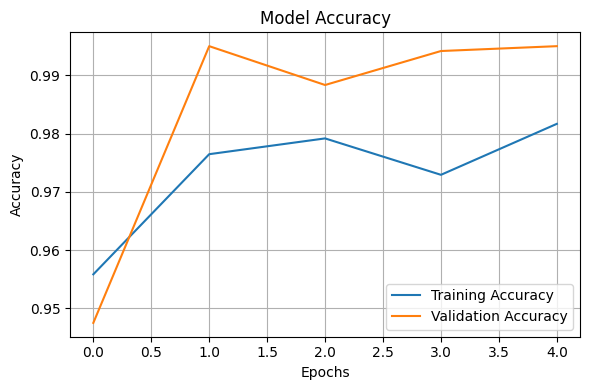

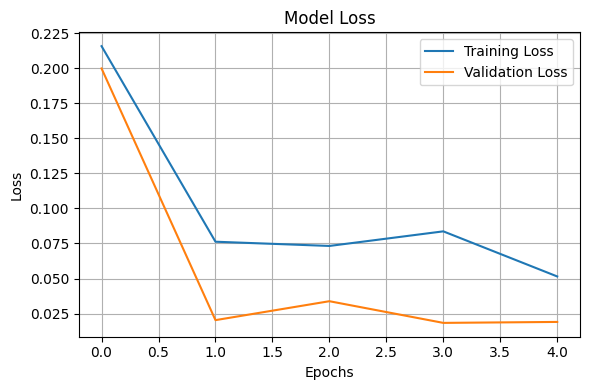

In [28]:
fig_w, fig_h = 6,4
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(tr_acc_all, label='Training Accuracy')
axs.plot(te_acc_all, label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(tr_loss_all, label='Training Loss')
axs.plot(te_loss_all, label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

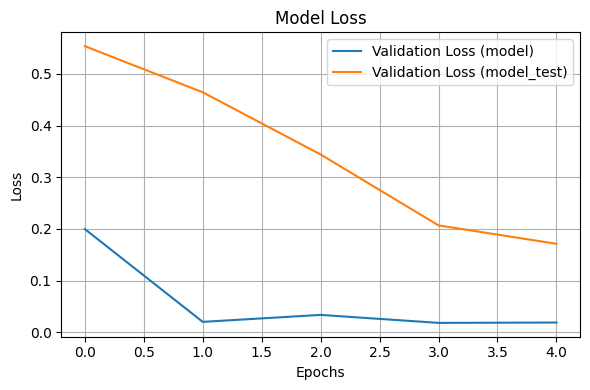

In [29]:
## Please use the space below to write your answer
fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(te_loss_all, label='Validation Loss (model)')
axs.plot(te_loss_all_test, label='Validation Loss (model_test)')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

